# Toy Problem - Lie group approach
Another way we could approach this state estimation task is to instead use Lie group theory, which is becoming increasingly common practice in state estimation. Lie group theory can be very abstract, and the main references that navlie refer to are the following:

1. [A micro Lie theory for state estimation in robotics](https://arxiv.org/abs/1812.01537)
2. [T.Barfoot, State Estimation for Robotics](http://asrl.utias.utoronto.ca/~tdb/bib/barfoot_ser17.pdf)


## Define the State
Instead of representing the state using a vector, we will represent the state using an element of the *special Euclidean group* $SE(2)$, sometimes called *pose transformation matrices*. Elements of this group are 3x3 matrices of the form 

$$ 
\mathbf{T} = \begin{bmatrix} \mathbf{C}_{ab}(\theta) & \mathbf{r}_a \\ \mathbf{0} & 1 \end{bmatrix} \in SE(2)
$$

where $\mathbf{r}_a = [x,y]^T$ again denotes the position of the robot and $\mathbf{C}_{ab}(\theta) \in SO(2)$ is a rotation matrix (sometimes called a direction cosine matrix) with the form 

$$ 
\mathbf{C}_{ab}(\theta) = \begin{bmatrix} \cos \theta & - \sin \theta \\ \sin \theta & \cos \theta \end{bmatrix}.
$$

The rotation matrix transforms vectors resolved in one frame to another frame, i.e. $\mathbf{r}_a = \mathbf{C}_{ab} \mathbf{r}_b$. Unlike vectors, elements of $SO(2)$ or $SE(2)$ cannot be added together to produce another valid element of $SE(2)$, but they can be multiplied together with the result still having the same form.

$$
\mathbf{T}_1 \mathbf{T}_2 \in SE(2)
$$

 To proceed further with our mathematical setup, we need to define a few very common operators seen in Lie group theory. The first two are the "wedge" $(\cdot)^\wedge$ and "vee" $(\cdot)^\vee$ operators, which for this specific group has the form

$$ 
\begin{bmatrix} \theta \\ x \\ y \end{bmatrix}^\wedge = \begin{bmatrix} 0 & -\theta & x \\ \theta & 0 & y \\ 0 & 0 & 0 \end{bmatrix}
$$

and the $(\cdot)^\vee$ operator simply does the exact inverse of $(\cdot)^\wedge$. We can implement them as follows.



In [28]:
%reset -f
import numpy as np

# Helper functions for SE(2)
def wedge_se2(x):
    return np.array([[   0, -x[0], x[1]],
                     [x[0],     0, x[2]], 
                     [   0,     0,    0]])

def vee_se2(X):
    return np.array([X[1, 0], X[0, 2], X[1, 2]])



Two other fundamental relationships appearing in Lie group theory are the exponential (denoted $\exp$) and logarithmic (denoted $\log$) maps. While these have a deeper definition, for our case it suffices to think of them  as simply the [matrix exponential](https://en.wikipedia.org/wiki/Matrix_exponential) and [matrix logarithm](https://en.wikipedia.org/wiki/Logarithm_of_a_matrix). Using the wedge and vee operators for $SE(2)$ defined above, we can convert a 3x1 vector to an $SE(2)$ element and back as follows

In [32]:
from scipy.linalg import expm, logm

T = expm(wedge_se2(np.array([0.1, 0.2, 0.3])))
print("An element of SE2:")
print(T)

x = vee_se2(logm(T))
print("\nThe original vector 'representing' it:")
print(x)

An element of SE2:
[[ 0.99500417 -0.09983342  0.18467933]
 [ 0.09983342  0.99500417  0.30949192]
 [ 0.          0.          1.        ]]

The original vector 'representing' it:
[0.1 0.2 0.3]


We now have the tools we need to abstract-ify our problem a little bit. As commonly seen in the literature, we can define the so-called "oplus" and "ominus" operators as follows (sometimes called "boxplus" $\boxplus$ and "boxminus" $\boxminus$):

$$
\begin{aligned}
\mathbf{T}_2 &= \mathbf{T}_1 \oplus \boldsymbol{\xi} := \mathbf{T}_1 \exp(\boldsymbol{\xi}^\wedge)  \\
\boldsymbol{\varepsilon} &= \mathbf{T}_2 \ominus \mathbf{T}_1 := \log(\mathbf{T}_2^{-1} \mathbf{T}_1)^\vee
\end{aligned}
$$ 

Here, both $\boldsymbol{\varepsilon}, \boldsymbol{\xi} \in \mathbb{R}^3$ are 3x1 vectors. The $\oplus: SE(2) \times \mathbb{R}^3 \to SE(2)$ operator "adds" a vector to an $SE(2)$ element to produce another $SE(2)$ element, and the $\ominus:SE(2) \times SE(2) \to \mathbb{R}^3$ operator "subtracts" two $SE(2)$ elements to produce a vector that represents the "difference" between them. 


With this context, lets implement an $SE(2)$ state inside navlie's framework. To define a custom state, you must subclass the `nav.State` abstract class and you *must* implement the `plus`, `minus`, and `copy` methods. These methods play exactly the role of $\oplus$ and $\ominus$ described above, while the `copy` method is used to create a deep copy of that state object. In addition, state objects must hold an integer property named `dof` that specifies the *degrees of freedom* associated with that state. For $SE(2)$, this is 3.

In [8]:
import navlie as nav

class SE2State(nav.State):
    def __init__(self, value :np.ndarray, stamp: float):
        super().__init__(value=value, dof=3, stamp=stamp)

    def plus(self, dx: np.ndarray):
        new_value = self.value @ expm(wedge_se2(dx))
        return SE2State(new_value, self.stamp)

    def minus(self, other: "SE2State"):
        other_inv = np.linalg.inv(other.value)
        return vee_se2(logm(other_inv @ self.value))
    
    def copy(self):
        return SE2State(self.value.copy(), self.stamp)

x = SE2State(np.eye(3), 0.0)
print(x)

SE2State(stamp=0.0, dof=3, state_id=None)
    [[1. 0. 0.]
     [0. 1. 0.]
     [0. 0. 1.]]


## Define the Process Model

Now, we must adapt the process model to work with our new `SE2State`. It is well known that the rotational kinematics can be written directly in terms of rotation matrices using 

$$ 
\dot{\mathbf{C}}_{ab} = \mathbf{C}_{ab}\begin{bmatrix}0 & -\theta \\ \theta & 0 \end{bmatrix} 
$$

and that the translational kinematics can be written in vector form using 

$$ 
\dot{\mathbf{r}}_a = \mathbf{C}_{ab} \begin{bmatrix} v \\ 0 \end{bmatrix} .
$$

By stacking these into matrices it follows that 
$$ 
\dot{\mathbf{T}} = \mathbf{T} \boldsymbol{\varpi}^\wedge
$$

where $\boldsymbol{\varpi} = [\omega, v, 0]^T$. This equation is now a linear, matrix-valued ODE, and can be integrated exactly over a short duration $\Delta t = t_{k+1} - t_k$ using the matrix exponential. This gives us the following discrete-time process model:

$$
\mathbf{T}_{k+1} = \mathbf{T}_k \exp(\boldsymbol{\varpi}_k^\wedge \Delta t)
$$

which we can implement as follows

In [9]:
class WheeledRobotSE2(nav.ProcessModel):
    def __init__(self, input_covariance_matrix):
        self.Q = input_covariance_matrix

    def evaluate(self, x:SE2State, u:nav.VectorInput, dt:float):
        u = np.array([u.value[0], u.value[1], 0])
        x_next = x.copy()
        x_next.value = x.value @ expm(wedge_se2(u * dt))
        return x_next
    
    def input_covariance(self, x:SE2State, u:nav.VectorInput, dt:float):
        return self.Q

Q = np.eye(2) * 0.1**2
process_model = WheeledRobotSE2(Q)

## Define the Measurement Model

Finally, our measurement model remains largely unchanged. We just need to ensure extract the position from an `SE2State` object now, as done below.

In [10]:
class RangeToLandmarkSE2(nav.MeasurementModel):
    def __init__(
        self,
        landmark_position: np.ndarray,
        measurement_covariance: float,
    ):
        self.landmark_position = landmark_position
        self.R = measurement_covariance

    def evaluate(self, x: SE2State):
        pos = x.value[0:2, 2]
        return np.linalg.norm(pos - self.landmark_position)

    def covariance(self, x: SE2State):
        return self.R
    

landmarks = np.array([[1, 1], [1, 2], [2, 2], [2, 1]])
meas_models = [RangeToLandmarkSE2(landmark,  0.1**2) for landmark in landmarks]

## Run the Filter!

And that's it! All remaining snippets are now _literally_ copy-pasted from our previous approach with zero modifications. Using the abstraction framework in navlie, we can easily switch between different state representations and process/measurement models without having to change any of data generation or filtering code. 

In [ ]:
dg = nav.DataGenerator(
    process_model=process_model,                  # process model to use
    input_func=lambda t, x: np.array([0.5, 0.3]), # a callable that specifies the input values over time
    input_covariance= Q,                          # numpy array or callable that specifies the input covariance over time
    input_freq=50,                                # the frequency (Hz) at which the input is sampled (and the process model integrated)
    meas_model_list=meas_models,                  # a list of measurement models to use
    meas_freq_list=[10, 10, 10, 10]               # corresponding measurement frequencies (Hz)
)

state_data, input_data, meas_data = dg.generate(x, start=0, stop=30, noise=True)

print(state_data[1])
print(input_data[2])
print(meas_data[3])

SE2State(stamp=0.02, dof=3, state_id=None)
    [[ 9.99950000e-01 -9.99983333e-03  5.99990000e-03]
     [ 9.99983333e-03  9.99950000e-01  2.99997500e-05]
     [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
VectorInput(stamp=0.04, state_id=None)
    [0.52438924 0.40056502]
Measurement(stamp=0.0, state_id=None) of PoseRangeToLandMark
    2.299276237837416


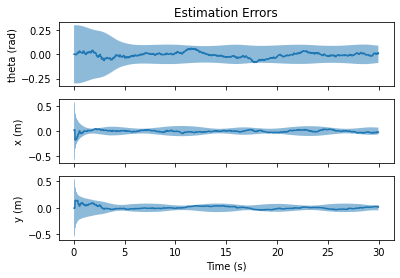

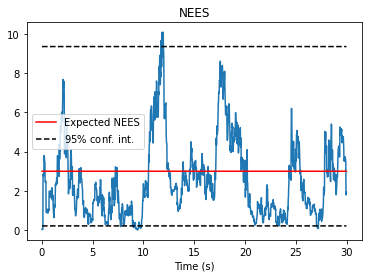

In [12]:
# First, define the filter
kalman_filter = nav.ExtendedKalmanFilter(process_model)
P0 = np.diag([0.1**2, 1**2, 1**2])  # Initial covariance
x = nav.StateWithCovariance(x, P0)  # Estimate and covariance in one container

meas_idx = 0
y = meas_data[meas_idx]
estimates = []
for k in range(len(input_data) - 1):
    u = input_data[k]

    # Fuse any measurements that have occurred.
    while y.stamp < input_data[k + 1].stamp and meas_idx < len(meas_data):
        x = kalman_filter.correct(x, y, u)

        # Load the next measurement
        meas_idx += 1
        if meas_idx < len(meas_data):
            y = meas_data[meas_idx]

    # Predict until the next input is available
    dt = input_data[k + 1].stamp - x.state.stamp
    x = kalman_filter.predict(x, u, dt)

    estimates.append(x.copy())


results = nav.GaussianResultList.from_estimates(estimates, state_data)

import matplotlib.pyplot as plt
fig, axs = nav.plot_error(results)
axs[0].set_title("Estimation Errors")
axs[0].set_ylabel("theta (rad)")
axs[1].set_ylabel("x (m)")
axs[2].set_ylabel("y (m)")
axs[2].set_xlabel("Time (s)")

fig, ax = nav.plot_nees(results)
ax.set_title("NEES")
ax.set_xlabel("Time (s)")
plt.show()

## Built-in Lie group states 
While we implemented our own `SE2State` from scratch here for pedagogical purposes, navlie comes with many built-in Lie group states that you can use out of the box. Some of the built-in Lie group states include:

- `nav.lib.SO2State`: representing 2D rotations using, beloning to the group $SO(2)$
- `nav.lib.SO3State`: representing 3D rotations using, beloning to the group $SO(3)$
- `nav.lib.SE2State`: representing 2D poses using, beloning to the group $SE(2)$
- `nav.lib.SE3State`: representing 3D poses using, beloning to the group $SE(3)$
- `nav.lib.SE23State`: representing "extended" poses that also contain velocity information, belonging to the group $SE_2(3)$
- `nav.lib.SL3State`: representing 3D homographies, belonging to the group $SL(3)$

Each of these classes stores the value as a square numpy array in the `x.value` property. Moreover, closed-form formulas for the exponential and logarithmic maps have been implemented for each of these states, which is faster than using `scipy.linalg.expm` and `scipy.linalg.logm`. These underlying operations have even been implemented in C++ for maximum speed. 